In [1]:
import cv2
import numpy as np
import tensorflow as tf
import keras
import glob
import albumentations as A
import matplotlib.pyplot as plt
import time

2025-02-22 13:27:30.659325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 13:27:30.659470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 13:27:30.791711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DATASET FORMATION

In [2]:
tf.config.run_functions_eagerly(True) 

In [3]:
image_filename =  '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_images/*.jpg'
masks_filename = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_masks/*.jpg'

In [4]:
img_filename_list = []
for files in sorted(glob.glob(image_filename)):
    img_filename_list.append(files)
    
mask_filename_list = []
for files in sorted(glob.glob(masks_filename)):
    mask_filename_list.append(files)

In [5]:
print(len(img_filename_list))
print(len(mask_filename_list))

2683
2683


In [6]:
train_img_filename_list = img_filename_list[:1000]
train_mask_filename_list = mask_filename_list[:1000]

In [7]:
test_img_filename_list = img_filename_list[1500:2000]
test_mask_filename_list = mask_filename_list[1500:2000]

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train_img_filename_list, train_mask_filename_list))

In [9]:
def decode_images(img_filename, mask_filename):
    image_string = tf.io.read_file(img_filename)
    mask_string = tf.io.read_file(mask_filename)
    
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    mask = tf.image.decode_jpeg(mask_string, channels=1)
    
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    image = tf.image.resize(image, (256, 256))
    mask = tf.image.resize(mask, (256, 256))
    
    return image, mask

In [10]:
dataset = dataset.map(decode_images)
dataset = dataset.batch(16)
dataset = dataset.prefetch(1)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [11]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [12]:
im, m = next(iter(dataset))

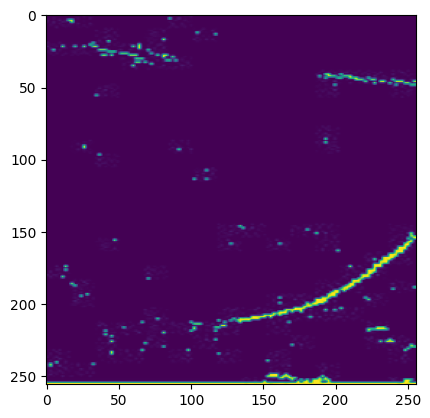

In [13]:
plt.imshow(m[5])

# UNET MODEL

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# U-Net model using functions
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding = 'same', activation = 'relu')(input)
  x = BatchNormalization()(x)

  x = Conv2D(num_filters, 3, padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(input)
  x = concatenate([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [15]:
inputs = Input((256, 256, 3))
s1, p1 = encoder_block(inputs, 64)
s2, p2 = encoder_block(p1, 128)
s3, p3 = encoder_block(p2, 256)
s4, p4 = encoder_block(p3, 512)

b1 = conv_block(p4, 1024)

d1 = decoder_block(b1, s4, 512)
d2 = decoder_block(d1, s3, 256)
d3 = decoder_block(d2, s2, 128)
d4 = decoder_block(d3, s1, 64)

outputs = Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# COMPILING AND TRAINING THE MODEL

In [16]:
model.compile(optimizer = 'adam', loss = keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [17]:
with tf.device("/device:GPU:0"):
    starting_time= time.time()
    history = model.fit(dataset, batch_size = 32, epochs = 50, verbose = 1)
    print('Total time', time.time() - starting_time)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5627 - loss: 0.6462 
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 876ms/step - accuracy: 0.6141 - loss: 0.5153
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 875ms/step - accuracy: 0.6143 - loss: 0.5089
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 871ms/step - accuracy: 0.6195 - loss: 0.5027
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 873ms/step - accuracy: 0.6215 - loss: 0.4948
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 872ms/step - accuracy: 0.6334 - loss: 0.4825
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 869ms/step - accuracy: 0.6328 - loss: 0.4808
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 870ms/step - accuracy: 0.6435 - loss: 0.4755
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 870ms/step - accuracy: 0.6556 - loss: 0.4543
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 872ms/step - accuracy: 0.6500 - loss: 0.4604
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 868ms/step - accuracy: 0.6564 - loss: 0.4473
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 

# PREDICTION USING TEST DATASET

In [18]:
test_img_file = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*.jpg'
test_img_files = []
for files in sorted(glob.glob(test_img_file)):
    test_img_files.append(files)

In [19]:
test_mask_file = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*.jpg'
test_mask_files = []
for files in sorted(glob.glob(test_mask_file)):
    test_mask_files.append(files)

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_img_files)

In [21]:
def decode_test_images(img_filename):
    image_string = tf.io.read_file(img_filename)
    
    
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
   
    
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    
    image = tf.image.resize(image, [256, 256])
    
    
    return image

In [22]:
test_dataset = test_dataset.map(decode_test_images)
#test_dataset = test_dataset.batch(16)

In [23]:
test_dataset = test_dataset.batch(16)

In [24]:
im = next(iter(test_dataset))

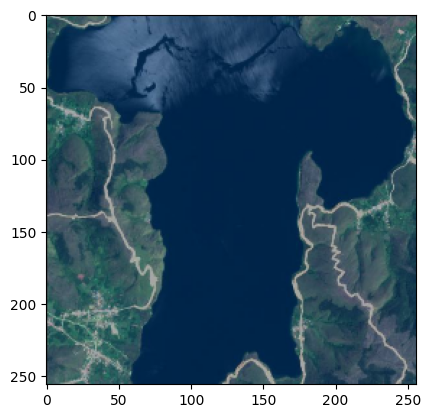

In [38]:
plt.imshow(im[2])

In [26]:
test_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [27]:
 output = model.predict(test_dataset, batch_size = 16)

178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step


In [28]:
output.shape

(2841, 256, 256, 1)

In [29]:
predictions = []
for i in  range(2683):
    pred = np.array(output[i])
    pred = (pred)
    predictions.append(pred)

In [30]:
y_test = []
for i in range(len(test_mask_files)):
    mask = tf.image.decode_jpeg(tf.io.read_file(test_mask_files[i]), channels = 1)
    mask = tf.image.resize(mask,[256, 256])
    y_test.append(mask)

In [31]:
# IoU measurement
iou_scores = []
for i in range(500):
    intersection = np.logical_and(y_test[i], predictions[i])
    union = np.logical_or(y_test[i], predictions[i])
    iou_score = np.sum(intersection)/np.sum(union)
    iou_scores.append(iou_score)
print(sum(iou_scores))
iou = sum(iou_scores)/2683
print("IoU score is : ", iou)

233.51036071777344
IoU score is :  0.08703330626827187


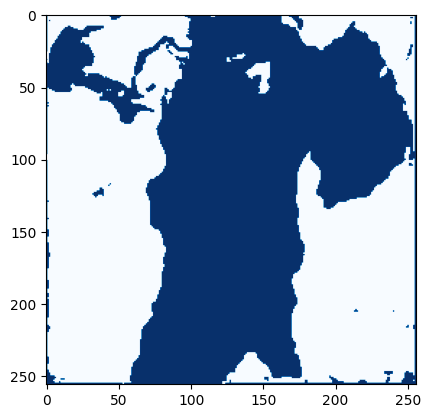

In [39]:
plt.imshow((output[2] > 0.1), cmap = 'Blues')

In [1]:
fig = plt.figure(figsize =(15, 15))
ax1 = fig.add_subplot(121)
ax1 = plt.imshow(im[0])
ax2 = fig.add_subplot(122)
ax2 = plt.imshow(predictions[9], cmap = 'Blues')

NameError: name 'plt' is not defined

In [4]:
# Save the trained model
model.save('/kaggle/working/unet_water_model.h5')  # Change path if needed


NameError: name 'model' is not defined

In [43]:
from IPython.display import FileLink

# Create a download link for the model
FileLink('/kaggle/working/unet_water_model.h5')


/kaggle/working/unet_water_model.h5

In [5]:
import shutil

# Move the model file to /kaggle/working
shutil.move('/kaggle/working/unet_water_model.h5', './unet_water_model.h5')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/unet_water_model.h5'

In [45]:
from IPython.display import FileLink

# Force generate a download link
FileLink('./unet_water_model.h5')


/kaggle/working/unet_water_model.h5